# Assign 5
## Armaan Dhanda

In [29]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import leastsq,curve_fit,minimize,Bounds,LinearConstraint,NonlinearConstraint
import matplotlib.pyplot as plt

In [30]:
d1=pd.read_csv('clicksdata.kw8322228.csv')
d2=pd.read_csv('clicksdata.kw8322392.csv')
d3=pd.read_csv('clicksdata.kw8322393.csv')
d4=pd.read_csv('clicksdata.kw8322445.csv')
d=[d1,d2,d3,d4]

## Part A

In [31]:
def loss(b,alpha,beta):
    return alpha*(1-np.exp(-beta*b))

In [32]:
coef=pd.DataFrame(columns=['alpha','beta','tss'])
j=0
for i in d:
    
    xalpha=i.loc[np.argmax(i['bid.value']),'n.clicks']
    xbeta=1/(i['bid.value'].mean())

    (coef.loc[j,'alpha'],coef.loc[j,'beta']),_=curve_fit(loss,i['bid.value'],i['n.clicks'],p0=[xalpha,xbeta])
    
    residuals = i['n.clicks'] - loss(i['bid.value'],coef.loc[j,'alpha'],coef.loc[j,'beta'])
    ss_res = np.sum(residuals**2)
    coef.loc[j,'tss']=ss_res

    j=j+1
    

In [33]:
rate=pd.read_excel('hw-kw-ltv-conv.rate-data.xlsx')

In [34]:
coef['keyword']=rate.keyword
coef

,alpha,beta,tss,keyword
0,74.090862,0.039449,229.814751,kw8322228
1,156.439803,0.150083,383.573004,kw8322392
2,104.799293,0.079717,216.308754,kw8322393
3,188.111279,0.432292,565.69058,kw8322445


## Part B

In [35]:
rate

,keyword,ltv,conv.rate
0,kw8322228,354,0.30
1,kw8322392,181,0.32
2,kw8322393,283,0.30
3,kw8322445,107,0.30


In [36]:
def nprofit(b,alpha,beta,k):
    return -alpha*(1-np.exp(-b*beta)) * (rate.loc[k,'ltv']*rate.loc[k,'conv.rate']-b)

def expenditure(b,alpha,beta,k):
    return alpha*(1-np.exp(-b*beta)) * b

In [37]:
bounds_object = Bounds(0, np.inf)

opt=pd.DataFrame(columns=['b','profit','expenditure'])
for i in range(len(rate)):
    opt.loc[i,'b']=minimize(nprofit,x0=d[i]['bid.value'].max(),args=(coef.loc[i,'alpha'],coef.loc[i,'beta'],i),method='trust-constr', bounds=bounds_object).x[0]
    opt.loc[i,'expenditure']=expenditure(opt.loc[i,'b'],coef.loc[i,'alpha'],coef.loc[i,'beta'],i)
    opt.loc[i,'profit']=-nprofit(opt.loc[i,'b'],coef.loc[i,'alpha'],coef.loc[i,'beta'],i)

/Users/vhr/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [38]:
opt['keyword']=rate.keyword
opt

,b,profit,expenditure,keyword
0,34.127623,3950.456962,1870.615465,kw8322228
1,13.563448,6032.902219,1844.75465,kw8322392
2,22.433868,5451.614108,1957.873607,kw8322393
3,5.816956,4544.188925,1005.718622,kw8322445


In [39]:
opt.expenditure.sum()

6678.962343970638

## Part C

In [40]:
def all_nprofit(b):
    s=0
    for i in range(4):
        s+=nprofit(b[i],coef.loc[i,'alpha'],coef.loc[i,'beta'],i)
    return s

def all_expenditure(b):
    s=0
    for i in range(4):
        s+=expenditure(b[i],coef.loc[i,'alpha'],coef.loc[i,'beta'],i)
    return s

In [41]:
x0 = opt.b.values

In [42]:
budget=3000
budget_constraint_object = NonlinearConstraint(all_expenditure, 0, budget)

In [43]:
b_all=minimize(all_nprofit,x0=x0,method='trust-constr', bounds=bounds_object,constraints=budget_constraint_object).x
b_all

/Users/vhr/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/vhr/anaconda3/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


array([17.92426062,  8.11845119, 12.82828837,  3.77569974])

In [44]:
final=pd.DataFrame(columns=['b','expenditure','profit'])
for i in range(4):
    final.loc[i]=[b_all[i],expenditure(b_all[i],coef.loc[i,'alpha'],coef.loc[i,'beta'],i),-nprofit(b_all[i],coef.loc[i,'alpha'],coef.loc[i,'beta'],i)]

In [45]:
final['keyword']=rate.keyword
final

,b,expenditure,profit,keyword
0,17.924261,673.208958,3315.507388,kw8322228
1,8.118451,894.506834,5487.232075,kw8322392
2,12.828288,860.885389,4836.614343,kw8322393
3,3.775700,571.398818,4286.482717,kw8322445


In [46]:
final.expenditure.sum()

2999.9999990950428

In [47]:
final.profit.sum()

17925.836522624388

## PART D

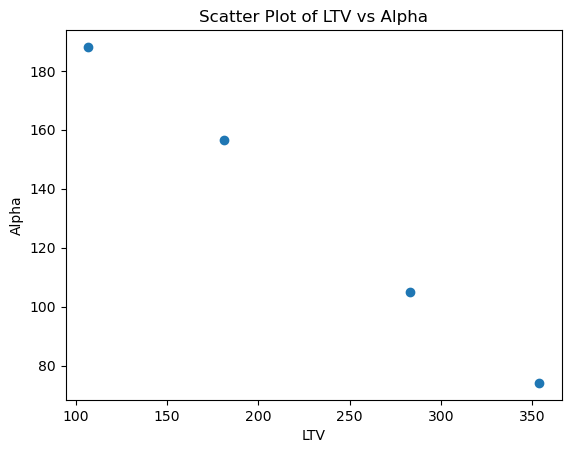

In [53]:
plt.scatter(rate.ltv, coef.alpha)
plt.xlabel('LTV')
plt.ylabel('Alpha')
plt.title('Scatter Plot of LTV vs Alpha')
plt.show()

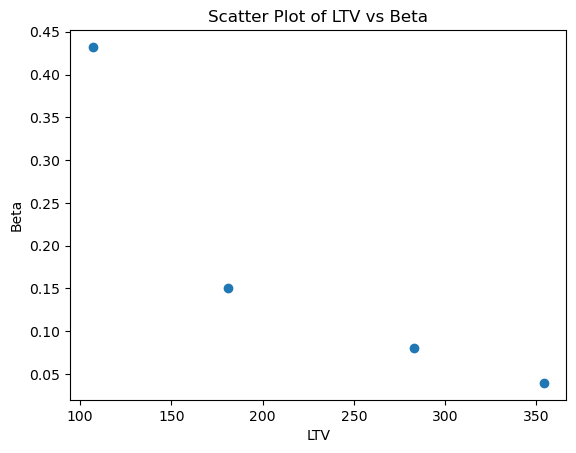

In [52]:
plt.scatter(rate.ltv, coef.beta)
plt.xlabel('LTV')
plt.ylabel('Beta')
plt.title('Scatter Plot of LTV vs Beta')
plt.show()

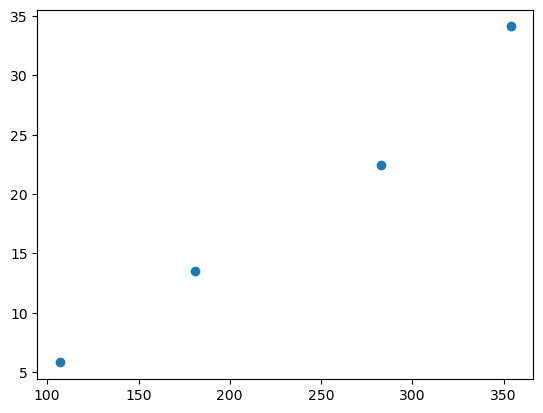

In [50]:
plt.scatter(rate.ltv,opt.b)

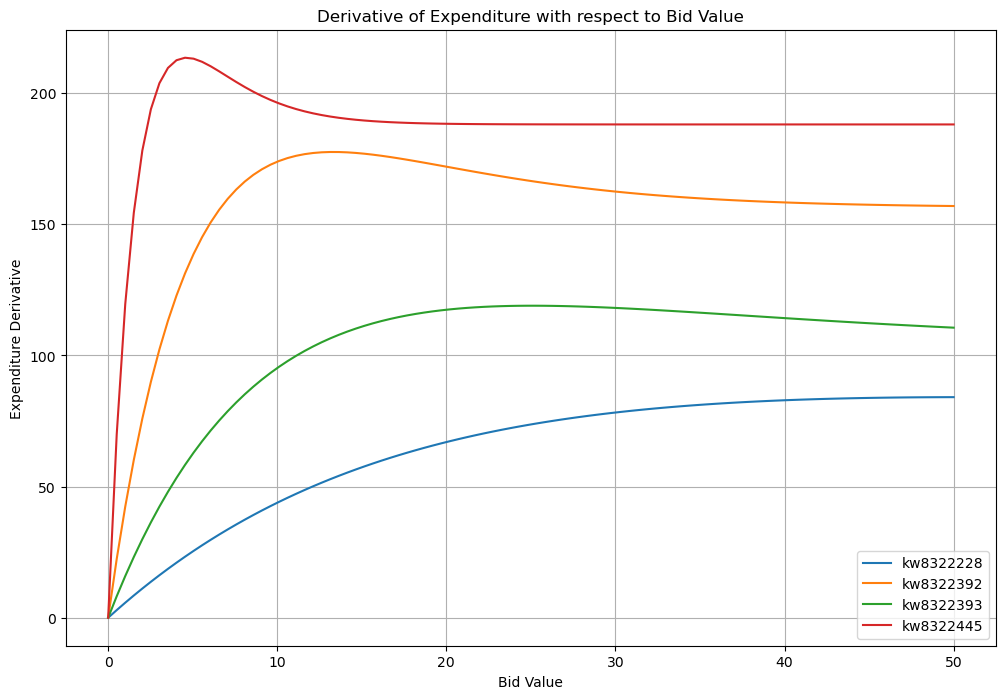

In [51]:
import matplotlib.pyplot as plt

# Define the expenditure derivative function
def expenditure_derivative(b, alpha, beta):
    return alpha * (1 - np.exp(-beta * b)) + alpha * b * beta * np.exp(-beta * b)

# Plot derivative curves
plt.figure(figsize=(12, 8))
b_values = np.linspace(0, 50, 100)
keywords = ["kw8322228", "kw8322392", "kw8322393", "kw8322445"]

for i, keyword in enumerate(keywords):
    alpha, beta = coef.loc[i, 'alpha'], coef.loc[i, 'beta']
    derivatives = expenditure_derivative(b_values, alpha, beta)
    plt.plot(b_values, derivatives, label=keyword)

plt.xlabel('Bid Value')
plt.ylabel('Expenditure Derivative')
plt.title('Derivative of Expenditure with respect to Bid Value')
plt.legend()
plt.grid(True)
plt.show()
